In [1]:
import pandas as pd
import os
import json
from scipy.stats import pearsonr, spearmanr
from tabulate import tabulate

## PROBE_HUMAN_AGREEMENT

In [18]:
MODELS = ["Qwen-Qwen2.5-Math-1.5B-Instruct", "Qwen-Qwen2.5-Math-7B-Instruct"]
# PROBING_DATASET = "gneubig_aime-1983-2024"
PROBING_DATASET = "DigitalLearningGmbH_MATH-lighteval"
LABELLED_DATASET = "DigitalLearningGmbH_MATH-lighteval"

In [19]:
if LABELLED_DATASET == "DigitalLearningGmbH_MATH-lighteval":
    BASE_COLS = ["problem_id", "problem", "score", 'level']
else:
    BASE_COLS = ["problem_id", "problem", "score"]

merged_df = None
K = 1
TEMP = 0.0

is_calibrated=True
if K==1:
    is_calibrated=False

for MODEL_NAME in MODELS:
    DATA_PATH = f"../probe_results/DATA/Labelled_SR/DigitalLearningGmbH_MATH-lighteval_probe/{LABELLED_DATASET}/{MODEL_NAME}_maxlen_3000_k_{K}_temp_{TEMP}/scored.parquet"
    temp_df = pd.read_parquet(DATA_PATH).copy()
    
    # Build columns to select dynamically (calibrated cols may not exist for k=1)
    cols_to_select = BASE_COLS.copy()
    if "calibrated_raw_score" in temp_df.columns:
        cols_to_select.append("calibrated_raw_score")
    if "calibrated_score" in temp_df.columns:
        cols_to_select.append("calibrated_score")
    
    temp_df = temp_df[cols_to_select]
    
    size = MODEL_NAME.split('-')[-2]  # e.g., '1.5B' or '7B'
    
    # Build rename dict dynamically
    rename_dict = {
        "score": f"score_{size}",
    }
    if "calibrated_raw_score" in temp_df.columns:
        rename_dict["calibrated_raw_score"] = f"calibrated_raw_score_{size}"
    if "calibrated_score" in temp_df.columns:
        rename_dict["calibrated_score"] = f"calibrated_score_{size}"
    
    temp_df = temp_df.rename(columns=rename_dict)
    
    if merged_df is None:
        merged_df = temp_df
    else:
        # Drop duplicate columns before merging
        cols_to_drop = ["problem", "level"] if "level" in temp_df.columns else ["problem"]
        merged_df = pd.merge(
            merged_df,
            temp_df.drop(columns=cols_to_drop),
            on="problem_id",
            suffixes=('', f'_{size}')
        )

if LABELLED_DATASET == "DigitalLearningGmbH_MATH-lighteval":
    merged_df["level"] = merged_df["level"].apply(lambda x: int(x.split(" ")[-1]))

In [20]:
merged_df

,problem_id,problem,score_1.5B,level,score_7B
0,SG93IG1hbnkgdmVydGljYWwgYXN5bXB0b3RlcyBkb2VzIH...,How many vertical asymptotes does the graph of...,0.983684,3,0.985458
1,V2hhdCBpcyB0aGUgcG9zaXRpdmUgZGlmZmVyZW5jZSBiZX...,What is the positive difference between $120\%...,0.994429,1,0.994638
2,RmluZCAkeCQgc3VjaCB0aGF0ICRcbGNlaWwgeCBccmNlaW...,Find $x$ such that $\lceil x \rceil + x = \dfr...,0.904985,4,0.903767
3,RXZhbHVhdGUgJGleNStpXnstMjV9K2leezQ1fSQuIExldC...,Evaluate $i^5+i^{-25}+i^{45}$. Let's think ste...,0.989266,5,0.977535
4,SWYgJDJeOD00XngkLCB3aGF0IGlzIHRoZSB2YWx1ZSBvZi...,"If $2^8=4^x$, what is the value of $x$? Let's ...",0.995147,1,0.994395
...,...,...,...,...,...
4995,SWYgJFxzaW4geCArIFxjb3MgeCA9IFxmcmFjezF9ezV9JC...,If $\sin x + \cos x = \frac{1}{5}$ and $0 < x ...,0.827057,5,0.937836
4996,VGhlIG1hdHJpeCBmb3IgcHJvamVjdGluZyBvbnRvIGEgY2...,The matrix for projecting onto a certain plane...,0.567240,5,0.683609
4997,TGV0ICRcbWF0aGJme2F9LCQgJFxtYXRoYmZ7Yn0sJCBhbm...,"Let $\mathbf{a},$ $\mathbf{b},$ and $\mathbf{c...",0.940794,4,0.969879
4998,RmluZCB0aGUgc21hbGxlc3QgcG9zaXRpdmUgaW50ZWdlci...,Find the smallest positive integer solution to...,0.667828,5,0.829897


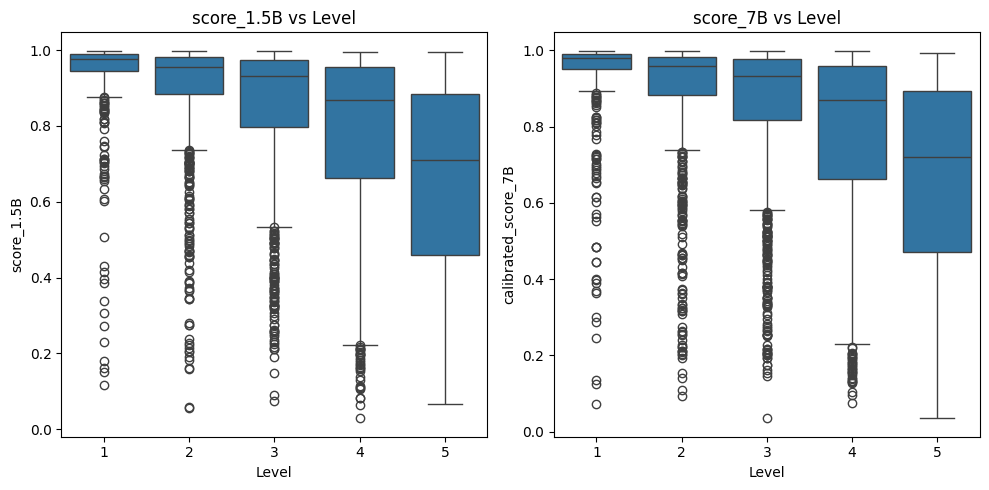

In [21]:
import seaborn as sns

import matplotlib.pyplot as plt

# Convert 'level' to numeric for correlation analysis
merged_df['level_num'] = pd.to_numeric(merged_df['level'], errors='coerce')

calibrated_str = "calibrated_score"

if is_calibrated == False:
    calibrated_str = "score"

plt.figure(figsize=(10, 5))

# Plot for calibrated_score_1.5B vs level
plt.subplot(1, 2, 1)
sns.boxplot(x='level_num', y=f'{calibrated_str}_1.5B', data=merged_df)
plt.title(f'{calibrated_str}_1.5B vs Level')
plt.xlabel('Level')
plt.ylabel(f'{calibrated_str}_1.5B')

# Plot forf {calibrated_str}_7B vs level
plt.subplot(1, 2, 2)
sns.boxplot(x='level_num', y=f'{calibrated_str}_7B', data=merged_df)
plt.title(f'{calibrated_str}_7B vs Level')
plt.xlabel('Level')
plt.ylabel('calibrated_score_7B')

plt.tight_layout()
plt.show()

In [22]:
print(
    f"Correlation between human difficulty annotations and SR predicted difficulty\n"
    f"Dataset: {LABELLED_DATASET} | Probes trained on: {PROBING_DATASET}\n"
)

# Get available score columns
score_cols = [col for col in merged_df.columns if col.startswith('score_')]
calibrated_score_cols = [col for col in merged_df.columns if col.startswith('calibrated_score_')]

results = [
    ["Model", "Score Type", "Spearman Correlation", "p-value"],
]

for score_col in score_cols:
    model_name = score_col.replace('score_', '')
    # Raw score - Spearman only
    corr, pval = spearmanr(merged_df[score_col], merged_df['level_num'])
    results.append([model_name, "Raw", f"{corr:.4f}", f"{pval:.4g}"])

# Add calibrated scores if they exist
for cal_score_col in calibrated_score_cols:
    model_name = cal_score_col.replace('calibrated_score_', '')
    # Calibrated score - Spearman only
    corr, pval = spearmanr(merged_df[cal_score_col], merged_df['level_num'])
    results.append([model_name, "Calibrated", f"{corr:.4f}", f"{pval:.4g}"])

print(tabulate(results[1:], headers=results[0], tablefmt="github"))
print()
print("Note: Human levels are annotated from 1 (easy) to 5 (hard).\n" \
"SR scores: higher means easier (1 = easy, 0 = hard).\n" \
"Spearman correlation measures rank-order agreement (appropriate for ordinal human labels).")

Correlation between human difficulty annotations and SR predicted difficulty
Dataset: DigitalLearningGmbH_MATH-lighteval | Probes trained on: DigitalLearningGmbH_MATH-lighteval

| Model   | Score Type   |   Spearman Correlation |    p-value |
|---------|--------------|------------------------|------------|
| 1.5B    | Raw          |                -0.4759 | 4.784e-281 |
| 7B      | Raw          |                -0.4668 | 3.953e-269 |

Note: Human levels are annotated from 1 (easy) to 5 (hard).
SR scores: higher means easier (1 = easy, 0 = hard).
Spearman correlation measures rank-order agreement (appropriate for ordinal human labels).


In [17]:
print(
    f"Correlation between human difficulty annotations and SR predicted difficulty\n"
    f"Dataset: {LABELLED_DATASET} | Probes trained on: {PROBING_DATASET}\n"
)

# Get available score columns
score_cols = [col for col in merged_df.columns if col.startswith('score_')]
calibrated_score_cols = [col for col in merged_df.columns if col.startswith('calibrated_score_')]

results = [
    ["Model", "Score Type", "Spearman Correlation", "p-value"],
]

for score_col in score_cols:
    model_name = score_col.replace('score_', '')
    # Raw score - Spearman only
    corr, pval = spearmanr(merged_df[score_col], merged_df['level_num'])
    results.append([model_name, "Raw", f"{corr:.4f}", f"{pval:.4g}"])

# Add calibrated scores if they exist
for cal_score_col in calibrated_score_cols:
    model_name = cal_score_col.replace('calibrated_score_', '')
    # Calibrated score - Spearman only
    corr, pval = spearmanr(merged_df[cal_score_col], merged_df['level_num'])
    results.append([model_name, "Calibrated", f"{corr:.4f}", f"{pval:.4g}"])

print(tabulate(results[1:], headers=results[0], tablefmt="github"))
print()
print("Note: Human levels are annotated from 1 (easy) to 5 (hard).\n" \
"SR scores: higher means easier (1 = easy, 0 = hard).\n" \
"Spearman correlation measures rank-order agreement (appropriate for ordinal human labels).")

Correlation between human difficulty annotations and SR predicted difficulty
Dataset: DigitalLearningGmbH_MATH-lighteval | Probes trained on: gneubig_aime-1983-2024

| Model   | Score Type   |   Spearman Correlation |    p-value |
|---------|--------------|------------------------|------------|
| 1.5B    | Raw          |                -0.4759 | 4.784e-281 |
| 7B      | Raw          |                -0.4668 | 3.953e-269 |

Note: Human levels are annotated from 1 (easy) to 5 (hard).
SR scores: higher means easier (1 = easy, 0 = hard).
Spearman correlation measures rank-order agreement (appropriate for ordinal human labels).


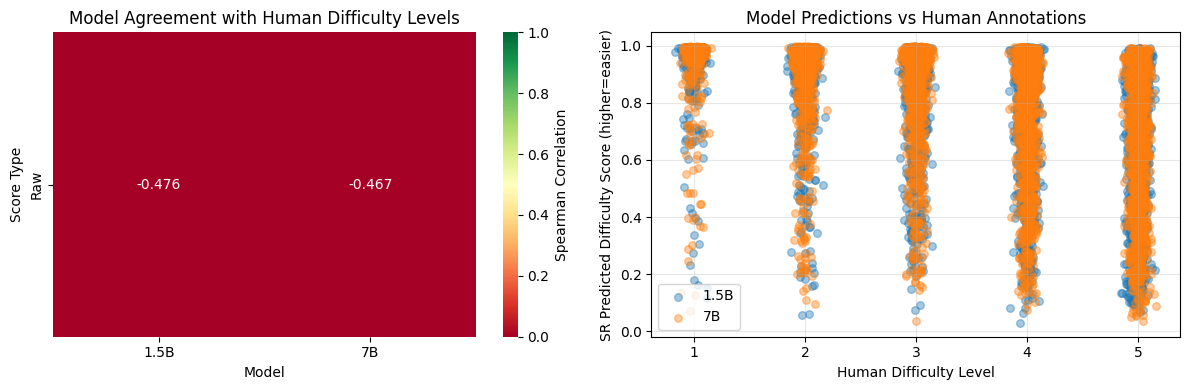


VISUALIZATION RECOMMENDATIONS FOR PAPER

1. PRIMARY FIGURE: Violin/box plot (already have this)
   - Shows distribution of scores per difficulty level
   - Clearly shows separability and prediction quality
   - Best for main paper

2. SECONDARY FIGURE: Correlation heatmap (shown above)
   - Compact comparison across models and score types
   - Good for supplementary material or methods section

3. TABLE: Summary statistics (Spearman ρ + p-values)
   - Keep table simple: Model | Spearman ρ | p-value
   - Highlight which models achieve significance (p < 0.05)

KEY MESSAGING IN PAPER:
- Emphasize that the probe successfully learns human difficulty preferences
- Mention that correlation is monotonic (Spearman appropriate for ordinal labels)
- Note any models that underperform (suggests routing may need adjustment)



In [12]:
## Visualization for Paper

import numpy as np

# Option 1: Heatmap of Spearman correlations
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Prepare data for heatmap
models = ['1.5B', '7B']
score_types = ['Raw', 'Calibrated'] if calibrated_score_cols else ['Raw']
corr_matrix = []
pval_matrix = []

for score_type in score_types:
    row_corr = []
    row_pval = []
    for model in models:
        if score_type == 'Raw':
            col_name = f'score_{model}'
        else:
            col_name = f'calibrated_score_{model}'
        
        if col_name in merged_df.columns:
            corr, pval = spearmanr(merged_df[col_name], merged_df['level_num'])
            row_corr.append(corr)
            row_pval.append(pval)
        else:
            row_corr.append(np.nan)
            row_pval.append(np.nan)
    corr_matrix.append(row_corr)
    pval_matrix.append(row_pval)

corr_matrix = np.array(corr_matrix)

# Plot 1: Heatmap
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='RdYlGn', vmin=0, vmax=1, 
            xticklabels=models, yticklabels=score_types, ax=axes[0], cbar_kws={'label': 'Spearman Correlation'})
axes[0].set_title('Model Agreement with Human Difficulty Levels')
axes[0].set_ylabel('Score Type')
axes[0].set_xlabel('Model')

# Plot 2: Scatter plot with trend (main paper figure)
ax = axes[1]
for model in models:
    col_name = f'score_{models[0]}' if model == models[0] else f'score_{models[1]}'
    # Add some jitter for visualization
    x = merged_df['level_num'] + np.random.normal(0, 0.05, len(merged_df))
    ax.scatter(x, merged_df[col_name], alpha=0.4, s=30, label=f'{model}')

ax.set_xlabel('Human Difficulty Level')
ax.set_ylabel('SR Predicted Difficulty Score (higher=easier)')
ax.set_title('Model Predictions vs Human Annotations')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("VISUALIZATION RECOMMENDATIONS FOR PAPER")
print("="*60)
print("""
1. PRIMARY FIGURE: Violin/box plot (already have this)
   - Shows distribution of scores per difficulty level
   - Clearly shows separability and prediction quality
   - Best for main paper

2. SECONDARY FIGURE: Correlation heatmap (shown above)
   - Compact comparison across models and score types
   - Good for supplementary material or methods section

3. TABLE: Summary statistics (Spearman ρ + p-values)
   - Keep table simple: Model | Spearman ρ | p-value
   - Highlight which models achieve significance (p < 0.05)

KEY MESSAGING IN PAPER:
- Emphasize that the probe successfully learns human difficulty preferences
- Mention that correlation is monotonic (Spearman appropriate for ordinal labels)
- Note any models that underperform (suggests routing may need adjustment)
""")